In [ ]:
# %% Deep learning - Section 10.96
#    More practice with multioutput ANNs

# This code pertains a deep learning course provided by Mike X. Cohen on Udemy:
#   > https://www.udemy.com/course/deeplearning_x
# The "base" code in this repository is adapted (with very minor modifications)
# from code developed by the course instructor (Mike X. Cohen), while the
# "exercises" and the "code challenges" contain more original solutions and
# creative input from my side. If you are interested in DL (and if you are
# reading this statement, chances are that you are), go check out the course, it
# is singularly good.


In [ ]:
# %% Libraries and modules
import numpy               as np
import matplotlib.pyplot   as plt
import torch
import torch.nn            as nn
import seaborn             as sns
import copy
import torch.nn.functional as F
import pandas              as pd
import scipy.stats         as stats
import time

from torch.utils.data                 import DataLoader,TensorDataset
from sklearn.model_selection          import train_test_split
from google.colab                     import files
from torchsummary                     import summary
from IPython                          import display
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')


In [ ]:
# %% Create data

# General params
n_by_clust = 300
blurring   = 1

# Centroids
A = [1,1]
B = [5,1]
C = [4,4]

# Generate data
a = [ A[0]+np.random.randn(n_by_clust)*blurring, A[1]+np.random.randn(n_by_clust)*blurring ]
b = [ B[0]+np.random.randn(n_by_clust)*blurring, B[1]+np.random.randn(n_by_clust)*blurring ]
c = [ C[0]+np.random.randn(n_by_clust)*blurring, C[1]+np.random.randn(n_by_clust)*blurring ]

# Labels
labels_np = np.hstack(( np.zeros((n_by_clust)),
                        np.ones((n_by_clust)),
                        2*np.ones((n_by_clust)) ))

# Data matrix
data_np = np.hstack((a,b,c)).T

# Data into PyTorch tensors (long format for CCE)
data   = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long()


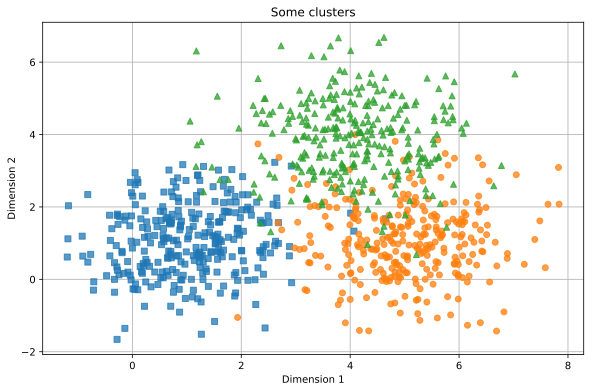

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# %% Plotting

phi = ( 1 + np.sqrt(5) ) / 2
fig = plt.figure(figsize=(6*phi,6))

plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'s',alpha=.75)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'o',alpha=.75)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'^',alpha=.75)

plt.title('Some clusters')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid()

plt.savefig('figure59_more_multioutput_ann.png')

plt.show()

files.download('figure59_more_multioutput_ann.png')


In [ ]:
# %% Split into train and test data

# Split with scikitlearn
train_data,test_data,train_labels,test_labels = train_test_split(data,labels,test_size=0.1)

# Convert into PyTorch datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Convert into DataLoader objects
batch_size   = 16
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])


In [ ]:
# %% Show batches number

print(f'There are {len(train_loader)} training batches, each with {batch_size} samples.')


There are 50 training batches, each with 16 samples.


In [ ]:
# %% Create the model

def gen_model():

    class model(nn.Module):
        def __init__(self):
            super().__init__()

            # Architecture
            self.input  = nn.Linear(2,8)
            self.hid1   = nn.Linear(8,8)
            self.output = nn.Linear(8,3)

        # Forward propagation
        def forward(self,x):
            x = F.relu(self.input(x))
            x = F.relu(self.hid1(x))
            x = self.output(x)

            return x

    # Model instance
    ANN = model()

    # Loss function and optimizer
    loss_fun  = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(ANN.parameters(),lr=0.01)

    return ANN,loss_fun,optimizer


In [ ]:
# %% Test model

ANN,loss_fun,optimizer = gen_model()
print(ANN)

# Fake input
inputs = torch.rand(10,2)
ANN(inputs)


model(
  (input): Linear(in_features=2, out_features=8, bias=True)
  (hid1): Linear(in_features=8, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=3, bias=True)
)


tensor([[-0.2756,  0.3007,  0.0331],
        [-0.2562,  0.2513,  0.0173],
        [-0.2430,  0.2873,  0.0210],
        [-0.2571,  0.2385,  0.0084],
        [-0.2468,  0.2600,  0.0134],
        [-0.2410,  0.2822,  0.0194],
        [-0.2432,  0.2370,  0.0054],
        [-0.2718,  0.2772,  0.0276],
        [-0.2524,  0.2411,  0.0132],
        [-0.2524,  0.2250,  0.0077]], grad_fn=<AddmmBackward0>)

In [ ]:
# %% Function to train the model

def train_model():

    # Epochs
    num_epochs = 100

    # Model instance
    ANN,loss_fun,optimizer = gen_model()

    # Initialise
    losses    = []
    train_acc = []
    test_acc  = []

    # Epochs loop
    for epoch_i in range(num_epochs):

        # Train mode on
        ANN.train()

        # Initialise and loop over batches
        batch_losses = []
        batch_acc    = []

        for X,y in train_loader:

            # Forward propagation and loss
            yHat = ANN(X)
            loss = loss_fun(yHat,y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute loss and accuracy from this batch
            batch_losses.append(loss.item())

            matches     = torch.argmax(yHat,axis=1) == y  # booleans
            matches_num = matches.float()                 # convert to numbers
            acc_percent = 100*torch.mean(matches_num)     # average and percent
            batch_acc.append(acc_percent)

        # Average train accuracy and losses from batches
        train_acc.append(np.mean(batch_acc))
        losses.append(np.mean(batch_losses))

        # Test accuracy (turn autograd off)
        ANN.eval()
        X,y = next(iter(test_loader))
        with torch.no_grad():
            yHat = ANN(X)
        test_acc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

    return train_acc,test_acc,losses,ANN


In [ ]:
# %% Run model

train_acc,test_acc,losses,ANN = train_model()


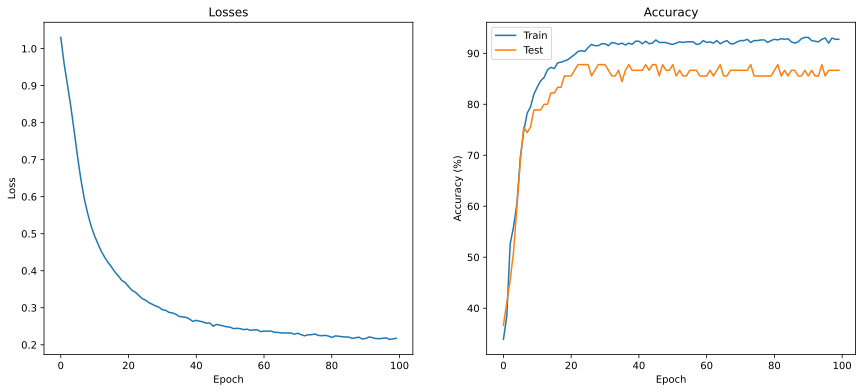

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# %% Plotting

phi = ( 1 + np.sqrt(5) ) / 2
fig,ax = plt.subplots(1,2,figsize=(1.5*6*phi,6))

ax[0].plot(losses)
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Losses')

ax[1].plot(train_acc,label='Train')
ax[1].plot(test_acc,label='Test')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy')
ax[1].legend()

plt.savefig('figure60_more_multioutput_ann.png')

plt.show()

files.download('figure60_more_multioutput_ann.png')


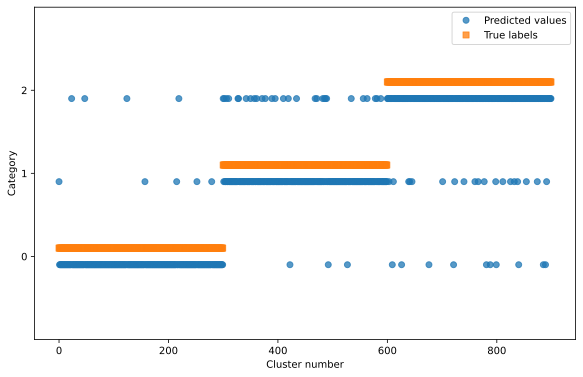

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# %% More plotting

# Get categorical predictions
yHat = ANN(data)
predictions = torch.argmax(yHat,axis=1)

phi = ( 1 + np.sqrt(5) ) / 2
fig = plt.figure(figsize=(6*phi,6))

plt.plot(predictions-0.1,'o',label='Predicted values',alpha=0.75)
plt.plot(labels+0.1,'s',label='True labels',alpha=0.75)

plt.xlabel('Cluster number')
plt.ylabel('Category')
plt.yticks([0,1,2])
plt.ylim([-1,3])
plt.legend()

plt.savefig('figure61_more_multioutput_ann.png')

plt.show()

files.download('figure61_more_multioutput_ann.png')


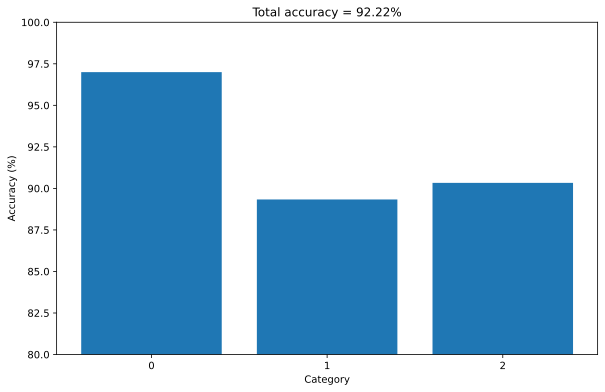

In [ ]:
# %% Quantify the errors

# Prediction by accuracy
accuracy = (predictions==labels).float()
tot_acc  = torch.mean(100*accuracy).item()

# Average by group
accuracy_by_group = np.zeros(3)
for i in range(3):
    accuracy_by_group[i] = 100*torch.mean(accuracy[labels==i])

# Plotting
phi = ( 1 + np.sqrt(5) ) / 2
fig = plt.figure(figsize=(6*phi,6))

plt.bar(range(3),accuracy_by_group)

plt.ylim([80,100])
plt.xticks([0,1,2])
plt.xlabel('Category')
plt.ylabel('Accuracy (%)')
plt.title(f'Total accuracy = {tot_acc:.2f}%')

plt.savefig('figure62_more_multioutput_ann.png')

plt.show()

files.download('figure62_more_multioutput_ann.png')


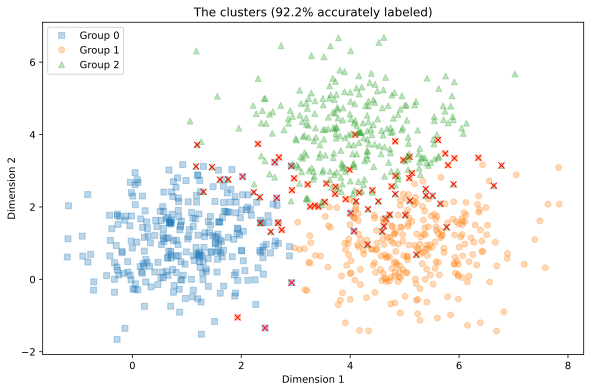

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# %% Show clusters in their native space, labeled by accuracy

# data markers
colorShapes = [ 's','o','^' ]

# Plotting
phi = ( 1 + np.sqrt(5) ) / 2
fig = plt.figure(figsize=(6*phi,6))

# Correct and incorrect labeled data
for i in range(3):
    plt.plot(data[labels==i,0],data[labels==i,1],
                colorShapes[i],alpha=.3,label=f'Group {i}')

    # cross out the incorrect ones
    idxErr = (accuracy==0) & (labels==i)
    plt.plot(data[idxErr,0],data[idxErr,1],'rx')

plt.title(f'The clusters ({tot_acc:.1f}% accurately labeled)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()

plt.savefig('figure63_more_multioutput_ann.png')

plt.show()

files.download('figure63_more_multioutput_ann.png')


In [ ]:
# %% Functions for 1D smoothing filter

# Improved for edge effects - adaptive window
def smooth_adaptive(x,k):
    smoothed = np.zeros_like(x)
    half_k   = k // 2

    for i in range(len(x)):
        start       = max(0, i-half_k)
        end         = min(len(x), i+half_k + 1)
        smoothed[i] = np.mean(x[start:end])

    return smoothed


In [ ]:
# %% Exercise 1
#    There are three categories and 8 units in the hidden layer. Is that more units than we need? Try re-running the model
#    with 3 units insted of 8. Does the model still perform well? Does it perform equally well on all three categories?

# The performance of the model doesn't change much, with 3 units in the hidden
# layer the model still performs as well as the one with 8 units


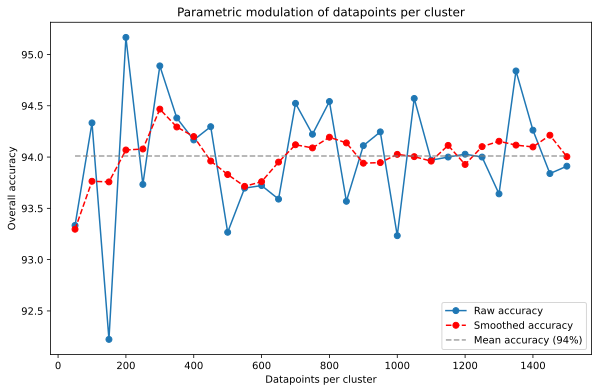

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# %% Exercise 2
#    One of the advantages of using simulated data is that you can have as much -- or as little -- data as possible. This
#    allows you to explore how much data the model needs for learning. Re-run this notebook using N=50/cluster (nb: you
#    might want to adjust the minibatch size). Is that enough to get good accuracy? Now try using N=1000/cluster. You can
#    run a parametric experiment to determine how model accuracy depends on the amount of data.

# Assuming the standard architecture with 8 units and fixed batch_size = 16, the
# accuracy of the model doesn't really change by increasing the number of datapoints,
# if anything, the performance maybe becomes a bit more stable as the datapoints
# increase

# Loop over data generation and model (~7 mins)
clust_sizes = np.arange(50,1501,50)
accuracies  = np.zeros(len(clust_sizes))

for i,size in enumerate(clust_sizes):

    # Generate data
    n_by_clust = int(size)
    blurring   = 1

    A = [1,1]
    B = [5,1]
    C = [4,4]

    a = [ A[0]+np.random.randn(n_by_clust)*blurring, A[1]+np.random.randn(n_by_clust)*blurring ]
    b = [ B[0]+np.random.randn(n_by_clust)*blurring, B[1]+np.random.randn(n_by_clust)*blurring ]
    c = [ C[0]+np.random.randn(n_by_clust)*blurring, C[1]+np.random.randn(n_by_clust)*blurring ]

    labels_np = np.hstack(( np.zeros((n_by_clust)),
                            np.ones((n_by_clust)),
                            2*np.ones((n_by_clust)) ))

    data_np = np.hstack((a,b,c)).T

    data   = torch.tensor(data_np).float()
    labels = torch.tensor(labels_np).long()

    # Split into train and test data
    train_data,test_data,train_labels,test_labels = train_test_split(data,labels,test_size=0.1)

    train_data = TensorDataset(train_data,train_labels)
    test_data  = TensorDataset(test_data,test_labels)

    batch_size   = 16
    train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True,drop_last=True)
    test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

    # Run the model
    train_acc,test_acc,losses,ANN = train_model()

    # Compute overall accuracy (call model, get preds, boolean, get acc)
    yHat          = ANN(data)
    predictions   = torch.argmax(yHat,axis=1)
    accuracy      = (predictions==labels).float()
    tot_acc       = torch.mean(100*accuracy).item()
    accuracies[i] = tot_acc

# Plotting
phi = ( 1 + np.sqrt(5) ) / 2
fig = plt.figure(figsize=(6*phi,6))

plt.plot(clust_sizes,accuracies,'o-',label='Raw accuracy')
plt.plot(clust_sizes,smooth_adaptive(accuracies,5),'ro--',label='Smoothed accuracy')
plt.plot(clust_sizes,np.mean(accuracies)*np.ones_like(clust_sizes),'--',color='gray',label=f'Mean accuracy ({np.mean(accuracies):.0f}%)',alpha=0.75)

plt.xlabel('Datapoints per cluster')
plt.ylabel('Overall accuracy')
plt.title('Parametric modulation of datapoints per cluster')
plt.legend()

plt.savefig('figure68_more_multioutput_ann_extra2.png')

plt.show()

files.download('figure68_more_multioutput_ann_extra2.png')


In [ ]:
# %% Exercise 3
#    Where do you put torch.no_grad() to crash the model? That is, find the one line (or maybe there is more than one?)
#    where the following crashes the model:
#
#      with torch.no_grad():
#        <key line here>
#
#    What does your discovery tell you about where during training the gradients are computed and used?

# Putting < with torch.no_grad(): > before the training part would effectively
# stop the computation of the gradient, thus vanifying the backpropagation and
# the updating of the weights. In fact, if I got it right, putting that line
# before the training batch loop will cause the code to crash and produce an
# error message
